# Gemma walk-through

This notebook contains a simplified version of Gemma (see "B. Gemma forward pass"), for sake of understanding/demystifying transformers. Accompanies a **[blog post](https://douglasorr.github.io/2024-04-transformers/article.html)** with the same goal.

 - Based on PyTorch ops, in most cases quite basic mathematical expressions.
 - Trying to be terse; intended use is to stare at the code for a while & optionally read through our blog that tries to explain each step.
 - Not designed with many useful features or to be particularly accurate (there are some numerics gotchas in replicating Gemma).

**[Run in Colab](https://colab.research.google.com/github/DouglasOrr/DouglasOrr.github.io/blob/examples/2024-04-transformers/gemma_walkthrough.ipynb)**

_If run-all doesn't work, it may be the (Colab or other) memory limit; this notebook flies quite close to 12 GB. If so, you can set `torch_dtype=torch.float16`, but this will make it run even slower on CPU._

---

# A. Preliminaries (skippable)

Imports; downloading the model parameters from Hugging Face; storing them in our own dataclass-based parameters structure.

_Downloads many GB & takes a while._

In [1]:
from dataclasses import dataclass
from typing import *
import unittest.mock as um

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import Tensor, nn
import transformers

In [2]:
model = transformers.AutoModelForCausalLM.from_pretrained("google/gemma-2b", torch_dtype=torch.float32)
tokenizer = transformers.AutoTokenizer.from_pretrained(model.config._name_or_path)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Load parameters


In [3]:
@dataclass
class NormParams:
    weight: Tensor
    eps: float

@dataclass
class AttentionParams:
    norm: NormParams
    q_proj: Tensor
    k_proj: Tensor
    v_proj: Tensor
    o_proj: Tensor
    num_key_value_heads: int
    rope_theta: float

@dataclass
class MlpParams:
    norm: NormParams
    gate_proj: Tensor
    up_proj: Tensor
    down_proj: Tensor

LayerParams = Tuple[AttentionParams, MlpParams]

@dataclass
class Params:
    embedding: Tensor
    layers: List[LayerParams]
    final_norm: NormParams

def get_huggingface_params(model: transformers.PreTrainedModel) -> Params:
    eps = model.config.rms_norm_eps
    return Params(
        embedding=model.model.embed_tokens.weight,
        layers=[(
                AttentionParams(
                    norm=NormParams(layer.input_layernorm.weight, eps=eps),
                    q_proj=layer.self_attn.q_proj.weight,
                    k_proj=layer.self_attn.k_proj.weight,
                    v_proj=layer.self_attn.v_proj.weight,
                    o_proj=layer.self_attn.o_proj.weight,
                    num_key_value_heads=model.config.num_key_value_heads,
                    rope_theta=model.config.rope_theta,
                ),
                MlpParams(
                    norm=NormParams(layer.post_attention_layernorm.weight, eps=eps),
                    gate_proj=layer.mlp.gate_proj.weight,
                    up_proj=layer.mlp.up_proj.weight,
                    down_proj=layer.mlp.down_proj.weight,
                )
            )
            for layer in model.model.layers
        ],
        final_norm=NormParams(model.model.norm.weight, eps=eps),
    )

def show(d: Any) -> Dict[str, Any]:
    if isinstance(d, Tensor):
        return f"Tensor{list(d.shape)}"
    if isinstance(d, tuple):
        return tuple(show(v) for v in d)
    if isinstance(d, list):
        return [f"{len(d)}x", show(d[0])]
    if hasattr(d, "__dict__"):
        return {k: show(v) for k, v in d.__dict__.items()}
    return d

params = get_huggingface_params(model)
display(show(params))

{'embedding': 'Tensor[256000, 2048]',
 'layers': ['18x',
  ({'norm': {'weight': 'Tensor[2048]', 'eps': 1e-06},
    'q_proj': 'Tensor[2048, 2048]',
    'k_proj': 'Tensor[256, 2048]',
    'v_proj': 'Tensor[256, 2048]',
    'o_proj': 'Tensor[2048, 2048]',
    'num_key_value_heads': 1,
    'rope_theta': 10000.0},
   {'norm': {'weight': 'Tensor[2048]', 'eps': 1e-06},
    'gate_proj': 'Tensor[16384, 2048]',
    'up_proj': 'Tensor[16384, 2048]',
    'down_proj': 'Tensor[2048, 16384]'})],
 'final_norm': {'weight': 'Tensor[2048]', 'eps': 1e-06}}

---

# B. Gemma forward pass

The main bit - Gemma-in-a-cell.

In [4]:
def rms_norm(p: NormParams, x: Tensor) -> Tensor:
    z = x.to(torch.float32, copy=True)
    z /= torch.sqrt((z ** 2).mean(-1, keepdim=True) + p.eps)
    z *= (1 + p.weight.float())
    return z.to(x.dtype)

def self_attn(q: Tensor, k: Tensor, v: Tensor) -> Tensor:
    a = torch.einsum("tnmd, snd -> nmts", q, k) / q.shape[-1] ** .5
    a += torch.full(a.shape[-2:], -torch.inf, dtype=a.dtype).tril_(-1).T
    a = a.softmax(dim=-1)
    return torch.einsum("nmts, snd -> tnmd", a, v)

def rotate(z: Tensor, cos: Tensor, sin: Tensor) -> Tensor:
    zx, zy = z.unflatten(-1, (2, -1)).movedim(-2, 0)
    return torch.cat([zx * cos - zy * sin, zy * cos + zx * sin], -1)

def embed_rotate(q: Tensor, k: Tensor, theta: float) -> Tensor:
    freq = (theta ** -(torch.arange(0, q.shape[-1], 2, dtype=torch.float) / q.shape[-1]))
    angle = torch.arange(q.shape[0])[:, None] * freq
    cos = angle.cos().to(q.dtype)
    sin = angle.sin().to(q.dtype)
    return (
        rotate(q, cos[:, None, None, :], sin[:, None, None, :]),
        rotate(k, cos[:, None, :], sin[:, None, :]),
    )

def attention(p: AttentionParams, x: Tensor) -> Tensor:
    k = (x @ p.k_proj.T).unflatten(-1, (p.num_key_value_heads, -1))
    q = (x @ p.q_proj.T).unflatten(-1, (p.num_key_value_heads, -1, k.shape[-1]))
    v = (x @ p.v_proj.T).unflatten(-1, (p.num_key_value_heads, -1))
    q, k = embed_rotate(q, k, theta=p.rope_theta)
    return self_attn(q, k, v).flatten(1) @ p.o_proj.T

def mlp(p: MlpParams, x: Tensor) -> Tensor:
    gate = x @ p.gate_proj.T
    up = x @ p.up_proj.T
    z = nn.functional.gelu(gate) * up
    return z @ p.down_proj.T

def predict(p: Params, input_ids: Tensor) -> Tensor:
    hiddens = p.embedding[input_ids]
    hiddens *= hiddens.shape[-1] ** .5
    for p_attn, p_mlp in p.layers:
        hiddens += attention(p_attn, rms_norm(p_attn.norm, hiddens))
        hiddens += mlp(p_mlp, rms_norm(p_mlp.norm, hiddens))
    hiddens = rms_norm(p.final_norm, hiddens)
    return hiddens @ p.embedding.T

input_ids = torch.tensor(tokenizer("I want to move").input_ids)
with torch.no_grad():
    logits = predict(params, input_ids)
print(tokenizer.decode(input_ids), "->", tokenizer.decode(logits[-1].argmax()))

<bos>I want to move ->  my


## A quick check against Hugging Face

In [5]:
with torch.no_grad():
    ref_logits = model(input_ids[None]).logits[0]

assert torch.equal(ref_logits.argmax(-1), logits.argmax(-1))

rtol = 1e-2
torch.testing.assert_close(logits.float(), ref_logits, rtol=rtol, atol=rtol * float(ref_logits.std()))

---

# C. Understanding plots (skippable)

Code to produce the diagrams from the blog post; for the extremely curious/tinker-ers only!

## 0. Dot product

In [6]:
def dot(a, b): return sum(a_i * b_i for a_i, b_i in zip(a, b))

tensor([ 2.0000,  0.7071,  0.0000, -0.7071, -1.0000])


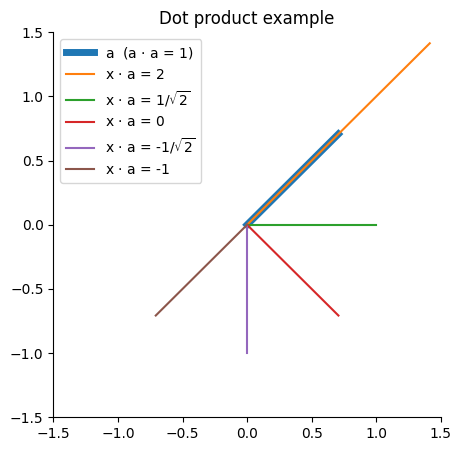

In [7]:
a = torch.tensor([2**-.5, 2**-.5])
vs = torch.tensor([[2*2**-.5, 2*2**-.5], [1, 0], [2**-.5, -2**-.5], [0, -1], [-2**-.5, -2**-.5]])
print((a * vs).sum(-1))
plt.figure(figsize=(5, 5))
plt.plot(*torch.stack([torch.zeros(2), a], dim=1), lw=5, label="a  (a $\cdot$ a = 1)")
plt.plot(*torch.stack([torch.zeros(2), vs[0]], dim=1), label="x $\cdot$ a = 2")
plt.plot(*torch.stack([torch.zeros(2), vs[1]], dim=1), label="x $\cdot$ a = $1/\sqrt{2}$")
plt.plot(*torch.stack([torch.zeros(2), vs[2]], dim=1), label="x $\cdot$ a = 0")
plt.plot(*torch.stack([torch.zeros(2), vs[3]], dim=1), label="x $\cdot$ a = -$1/\sqrt{2}$")
plt.plot(*torch.stack([torch.zeros(2), vs[4]], dim=1), label="x $\cdot$ a = -1")
plt.legend()
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.title("Dot product example")
sns.despine()

## 1. Tokenisation

In [8]:
len(tokenizer.vocab)

256000

In [9]:
input_ids = tokenizer("I want to move").input_ids
print(input_ids)
print(tokenizer.convert_ids_to_tokens(input_ids))

[2, 235285, 1938, 577, 3124]
['<bos>', 'I', '▁want', '▁to', '▁move']


In [10]:
input_ids = tokenizer("The superlative").input_ids
print(input_ids)
print(tokenizer.convert_ids_to_tokens(input_ids))

[2, 651, 2557, 133344]
['<bos>', 'The', '▁super', 'lative']


In [11]:
print((tokenizer.vocab["The"], tokenizer.vocab["the"]))

(651, 1175)


In [12]:
input_ids = tokenizer("nvdkjsv", add_special_tokens=False).input_ids
print(input_ids)
print(tokenizer.convert_ids_to_tokens(input_ids))

[235254, 9142, 235273, 2833, 235272]
['n', 'vd', 'k', 'js', 'v']


## 2. Embedding

In [13]:
input_ids = torch.tensor([100, 200, 300, 400, 500])
print(input_ids.shape)
print(params.embedding[input_ids].shape)

torch.Size([5])
torch.Size([5, 2048])


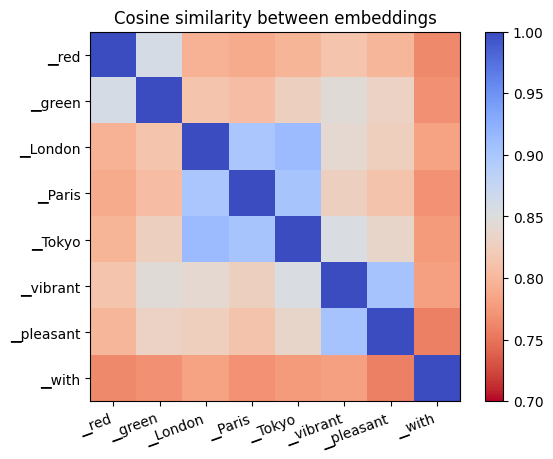

In [14]:
tokens = ["▁red", "▁green", "▁London", "▁Paris", "▁Tokyo", "▁vibrant", "▁pleasant", "▁with"]
input_ids = tokenizer.convert_tokens_to_ids(tokens)
embeddings = params.embedding[input_ids]
embeddings /= embeddings.norm(dim=-1, keepdim=True)
similarity = embeddings @ embeddings.T
ax = plt.gca()
m = ax.imshow(similarity.detach(), cmap="coolwarm_r", vmin=0.7)
plt.colorbar(m)
ax.set_xticks(range(len(tokens)), tokens, rotation=20, ha="right")
ax.set_yticks(range(len(tokens)), tokens)
ax.set_title("Cosine similarity between embeddings");

## 3. Embedding scaling

In [15]:
text = ("This is a sentence with a few words in it."
    " The content doesn't matter much, though."
    " Rambling on can be seriously hazardous to your health.")
hiddens = params.embedding[tokenizer(text).input_ids]
print(float(hiddens.std()))
hiddens *= hiddens.shape[-1] ** .5
print(float(hiddens.std()))

0.12356439977884293
5.591886043548584


In [16]:
hiddens = torch.randn(10, 2048)
print(float(hiddens.std()))
embedding_init = torch.randn(100, 2048) / 2048**0.5
logits = hiddens @ embedding_init.T
print(float(logits.std()))

1.0012602806091309
1.0106228590011597


## 4. Transformer (residual) layers

In [17]:
update_scales_attention = []
update_scales_mlp = []
def predict_debug(p: Params, input_ids: Tensor) -> Tensor:
    hiddens = p.embedding[input_ids]
    hiddens *= hiddens.shape[-1] ** .5
    for p_attn, p_mlp in p.layers:
        z = attention(p_attn, rms_norm(p_attn.norm, hiddens))
        update_scales_attention.append(float((z.var() / (hiddens.var() + z.var())).sqrt()))
        hiddens += z
        z = mlp(p_mlp, rms_norm(p_mlp.norm, hiddens))
        update_scales_mlp.append(float((z.var() / (hiddens.var() + z.var())).sqrt()))
        hiddens += z
    hiddens = rms_norm(p.final_norm, hiddens)
    return hiddens @ p.embedding.T

with torch.no_grad():
    predict_debug(params, torch.tensor(tokenizer("I want to move").input_ids))

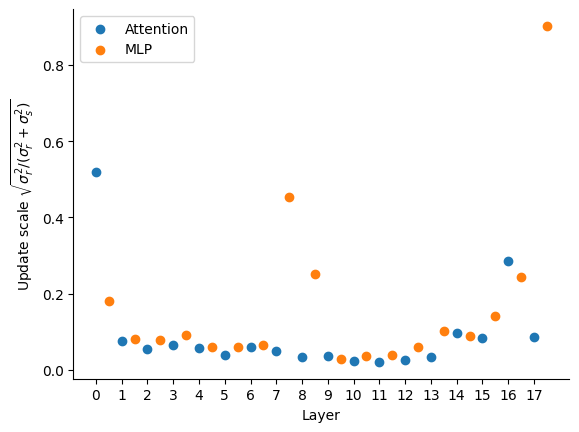

In [18]:
x = torch.arange(18)
plt.scatter(x, update_scales_attention, label="Attention")
plt.scatter(x + .5, update_scales_mlp, label="MLP")
plt.xticks(x)
plt.ylabel(r"Update scale $\sqrt{\sigma_r^2 / (\sigma_r^2 + \sigma_s^2)}$")
plt.xlabel("Layer")
plt.legend()
sns.despine()

## 5. RMS Norm

In [19]:
# Without norm
hiddens = 1
for _ in range(18):
    hiddens += 2 * hiddens  # layer(x) = 2 * x
print(hiddens)

# With norm
hiddens = 1
for _ in range(18):
    hiddens += 2  # layer(norm(x)) = 2
print(hiddens)

387420489
37


In [20]:
scales = []
def predict_debug(p: Params, input_ids: Tensor) -> Tensor:
    hiddens = p.embedding[input_ids]
    hiddens *= hiddens.shape[-1] ** .5
    for p_attn, p_mlp in p.layers:
        scales.append(float(hiddens.std()))
        hiddens += attention(p_attn, rms_norm(p_attn.norm, hiddens))
        scales.append(float(hiddens.std()))
        hiddens += mlp(p_mlp, rms_norm(p_mlp.norm, hiddens))
    scales.append(float(hiddens.std()))
    hiddens = rms_norm(p.final_norm, hiddens)
    scales.append(float(hiddens.std()))
    return hiddens @ p.embedding.T

input_ids = torch.tensor(tokenizer("I want to move").input_ids)
with torch.no_grad():
    predict_debug(params, input_ids)
    scales_with_norm = scales
    scales = []

with torch.no_grad(), um.patch("__main__.rms_norm", lambda _, x: x):
    predict_debug(params, input_ids)
    scales_without_norm = scales
    scales = []

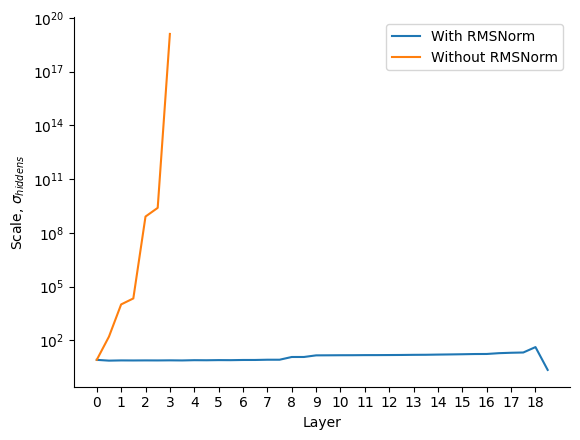

In [21]:
xs = torch.arange(0, 19, 0.5)
plt.plot(xs, scales_with_norm, label="With RMSNorm")
plt.plot(xs, scales_without_norm, label="Without RMSNorm")
plt.yscale("log")
plt.xlabel("Layer")
plt.ylabel("Scale, $\sigma_{hiddens}$")
plt.xticks(xs[::2])
plt.legend()
sns.despine()

## 6. Attention

In [22]:
attention_weights = []
def self_attn_debug(q: Tensor, k: Tensor, v: Tensor) -> Tensor:
    a = torch.einsum("tnmd, snd -> nmts", q, k) / q.shape[-1] ** .5
    a += torch.full(a.shape[-2:], -torch.inf, dtype=a.dtype).tril_(-1).T
    a = a.softmax(dim=-1)
    attention_weights.append(a)
    return torch.einsum("nmts, snd -> tnmd", a, v)

with torch.no_grad(), um.patch("__main__.self_attn", self_attn_debug):
    predict(params, input_ids)
attention_weights = torch.stack(attention_weights)

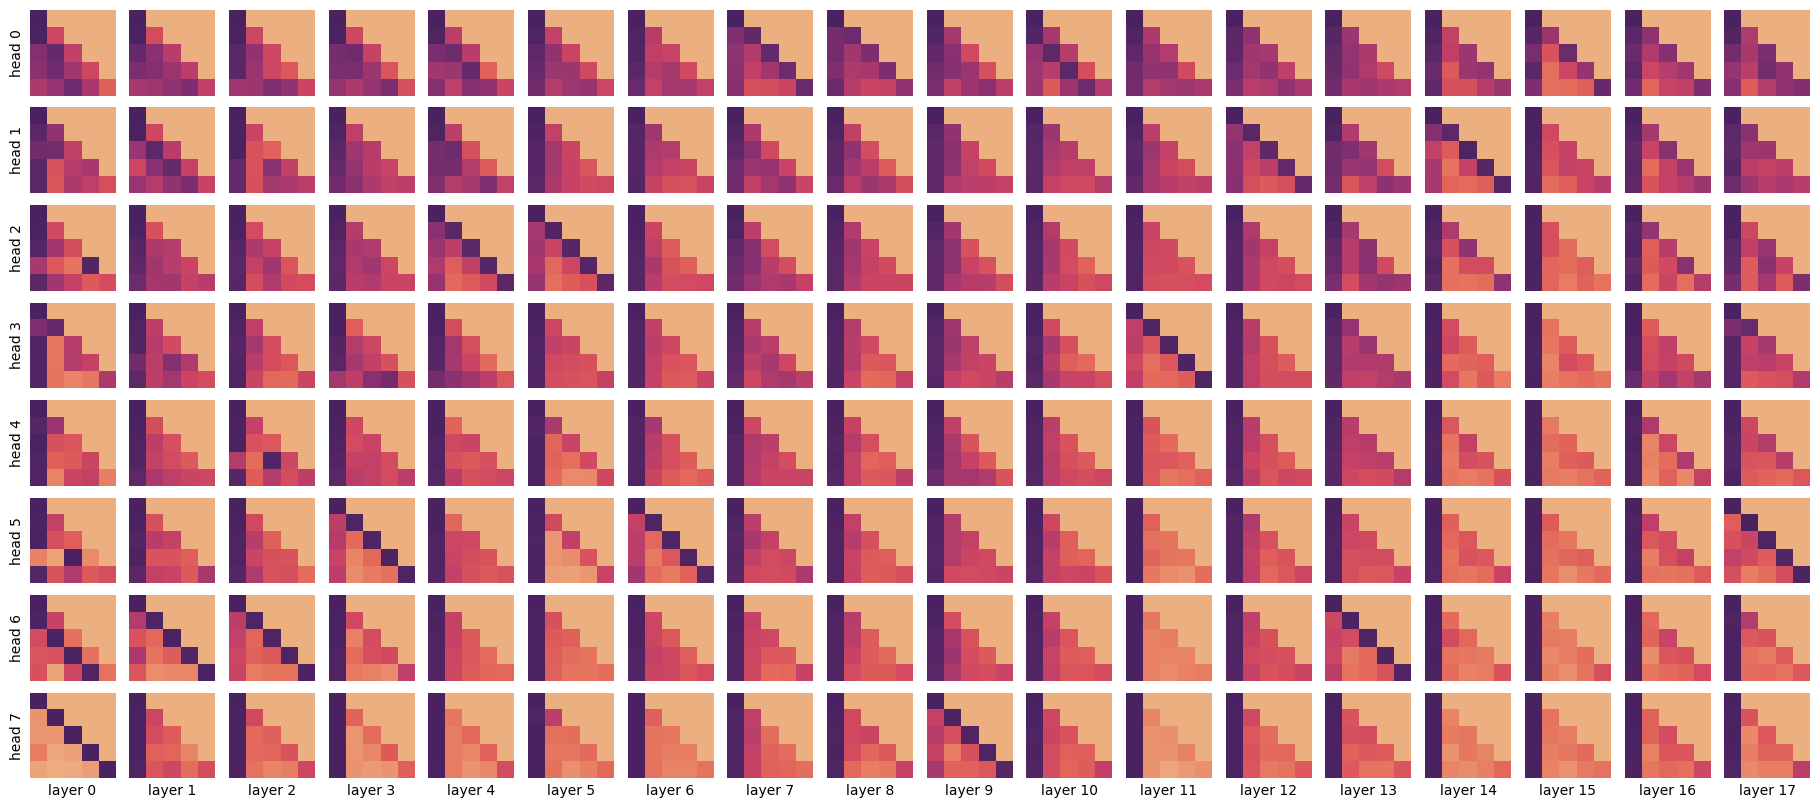

In [23]:
size = 1
nlayer, nhead = 3, 8
nlayer, nhead = 18, 8
_, axs = plt.subplots(nhead, nlayer, figsize=(nlayer*size, nhead*size))
for i, axc in enumerate(axs.T):
    weights = attention_weights[i, 0]
    entropy = (weights * weights.log().masked_fill(weights==0, 0)).mean((1, 2))
    row_order = torch.argsort(entropy)
    for j, ax in enumerate(axc):
        ax.imshow(weights[row_order[j]], cmap="flare", norm=matplotlib.colors.PowerNorm(gamma=1/4, vmin=0, vmax=1))
        ax.set_xticks([]); ax.set_yticks([])
        if j == nhead - 1:
            ax.set_xlabel(f"layer {i}")
        if i == 0:
            ax.set_ylabel(f"head {j}")
sns.despine(left=True, bottom=True)
plt.tight_layout(h_pad=0, w_pad=1, pad=0)

## 7. RoPE

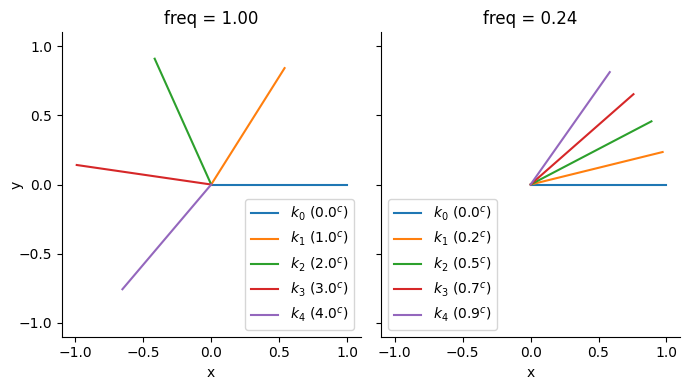

In [24]:
_rope_freqs = (10000 ** -(torch.arange(0, 256, 2, dtype=torch.float) / 256))
_, axs = plt.subplots(1, 2, figsize=(7, 4), sharey=True)
for f, ax in zip([_rope_freqs[0], _rope_freqs[20]], axs):
    angle = torch.arange(5) * f
    for i, a in enumerate(angle):
        ax.plot([0, a.cos()], [0, a.sin()], label=f"$k_{i}$ $({float(a):.1f}^c)$")
    ax.set_xlim((-1.1, 1.1))
    ax.set_ylim((-1.1, 1.1))
    ax.set_xticks([-1, -.5, 0, .5, 1])
    ax.set_yticks([-1, -.5, 0, .5, 1])
    ax.legend(loc="lower right" if ax is axs[0] else "lower left")
    ax.set_title(f"freq = {f:.2f}")
    ax.set_xlabel("x")
    if ax is axs[0]:
        ax.set_ylabel("y", labelpad=-4)
plt.tight_layout()
sns.despine()

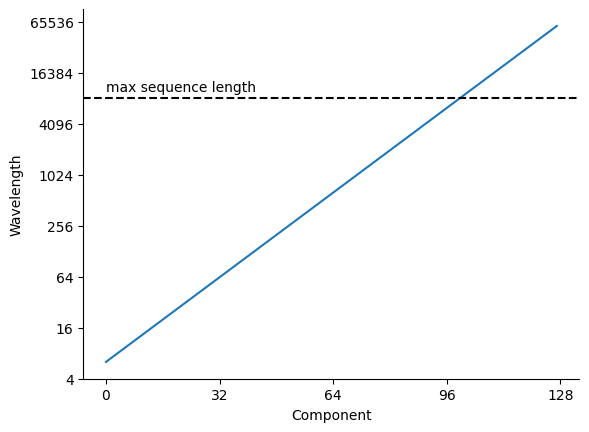

In [25]:
ax = plt.gca()
ax.plot(2*torch.pi/_rope_freqs)
ax.set_yscale("log", base=2)
ax.set_xlabel("Component")
ax.set_ylabel("Wavelength")
ax.set_xticks(torch.arange(0, 129, 32))
ax.set_yticks(2**torch.arange(2, 17, 2))
ax.yaxis.set_major_formatter("{x:.0f}")
ax.axhline(y=8192, color="k", linestyle="--")
ax.annotate("max sequence length", [0, 8192], xytext=[0, 5], textcoords="offset points")
sns.despine()

In [26]:
_q, _k = [], []
self_attn_original = self_attn
def self_attn_debug(q: Tensor, k: Tensor, v: Tensor) -> Tensor:
    _q.append(q)
    _k.append(k)
    return self_attn_original(q, k, v)

with torch.no_grad(), um.patch("__main__.self_attn", self_attn_debug):
    predict(params, input_ids)
_q, _k = torch.stack(_q), torch.stack(_k)

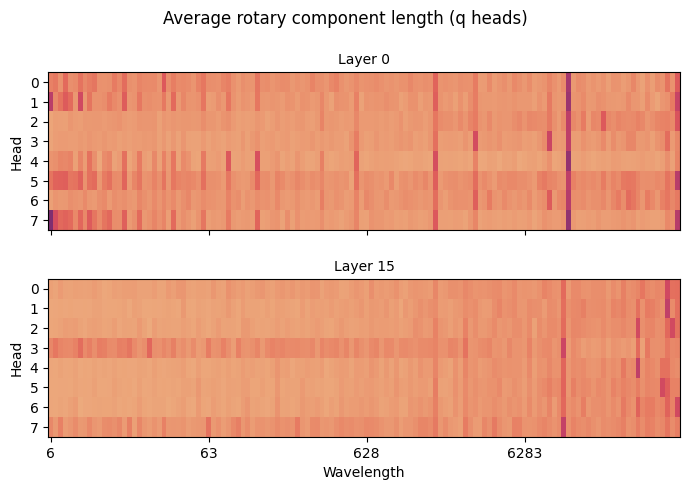

In [27]:
layers = [0, 15]
z = (_q[:, :, 0].unflatten(-1, (2, -1)) ** 2).sum(-2).sqrt()

_, axs = plt.subplots(2, 1, figsize=(7, 5), sharex=True)
norm = matplotlib.colors.PowerNorm(vmin=0, vmax=z.max(), gamma=.7)
axs[0].imshow(z[layers[0]].mean((0)), aspect=4, cmap="flare", norm=norm)
axs[1].imshow(z[layers[1]].mean((0)), aspect=4, cmap="flare", norm=norm)
axs[0].set_title(f"Layer {layers[0]}", fontsize=10)
axs[1].set_title(f"Layer {layers[1]}", fontsize=10)
axs[0].set_ylabel("Head")
axs[1].set_ylabel("Head")

axs[0].set_yticks(list(range(8)))
axs[1].set_yticks(list(range(8)))

xs = torch.arange(0, 128, 32)
axs[1].set_xticks(xs, [f"{x:.0f}" for x in (2*torch.pi/_rope_freqs)[xs]])
axs[1].set_xlabel("Wavelength")

plt.suptitle("Average rotary component length (q heads)");
plt.tight_layout()

## 8. MLP

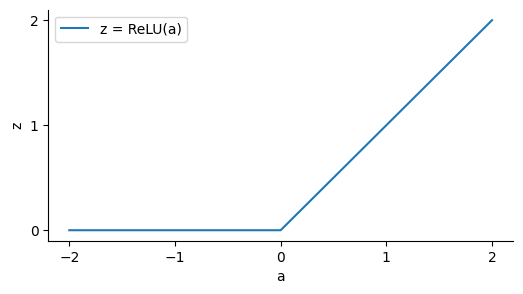

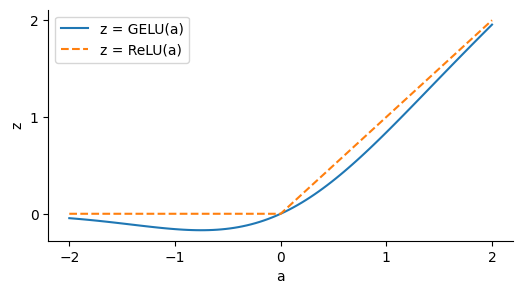

In [28]:
x = torch.linspace(-2, 2, 101)
for fn in ["relu", "gelu"]:
    plt.figure(figsize=(6, 3))
    ax = plt.gca()
    if fn == "gelu":
        ax.plot(x, nn.functional.gelu(x), label="z = GELU(a)")
    ax.plot(x, torch.relu(x), label="z = ReLU(a)", linestyle="--" if fn == "gelu" else "-")
    ax.set_ylabel("z")
    ax.set_xlabel("a")
    ax.legend()
    ax.set_xticks([-2, -1, 0, 1, 2])
    ax.set_yticks([0, 1, 2])
    sns.despine()

In [29]:
d = 3
lim = 2
count = 201

torch.manual_seed(20) # 500
gate_proj = torch.randn(2, d) / 2**.5
up_proj = torch.randn(2, d) / 2**.5
down_proj = torch.randn(d, 2) / d**.5
proj = torch.randn(2, 2) / 2**.5

x = torch.stack(torch.meshgrid(
    torch.linspace(-lim, lim, count),
    torch.linspace(-lim, lim, count),
    indexing="xy"), dim=-1)
gate = x @ gate_proj
up = x @ up_proj
y_linear = x @ proj
y_relu = torch.relu(gate) @ down_proj
y_gelu = nn.functional.gelu(gate) @ down_proj
y_reglu = (torch.relu(gate) * up) @ down_proj
y_geglu = (nn.functional.gelu(gate) * up) @ down_proj

z_colours = torch.tensor([[1.,0,0], [0,1,0], [0,0,1]])
c = 0.15 + (0 <= gate).float() @ z_colours *.6

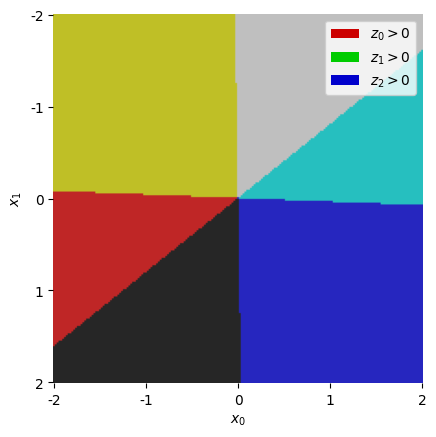

In [30]:
ax = plt.gca()
ax.imshow(c)
i = torch.linspace(0, x.shape[0] - 1, 5).long()
ax.set_xticks(i, [int(x[0, ii, 0]) for ii in i])
ax.set_yticks(i, [int(x[ii, 0, 1]) for ii in i])
ax.set_xlabel("$x_0$")
ax.set_ylabel("$x_1$")
ax.legend(handles=[
    matplotlib.patches.Patch(facecolor=(.8*z_colours[i]).tolist(), label=f"$z_{i} > 0$")
    for i in range(d)])
ax.spines[["left", "bottom", "right", "top"]].set_visible(False)

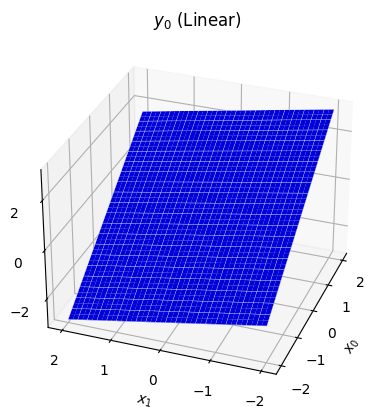

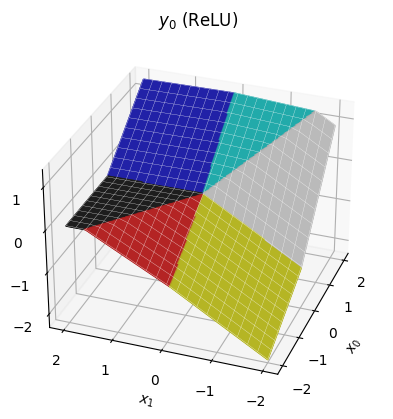

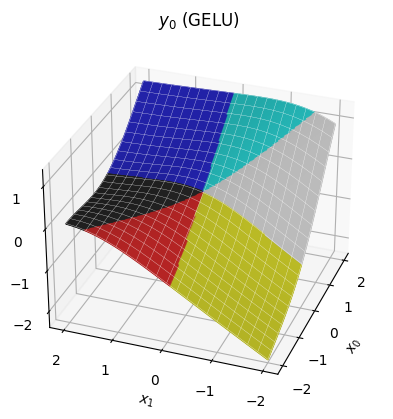

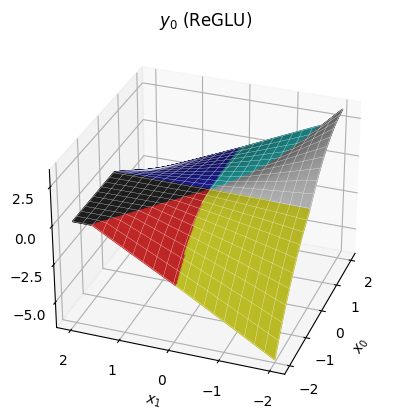

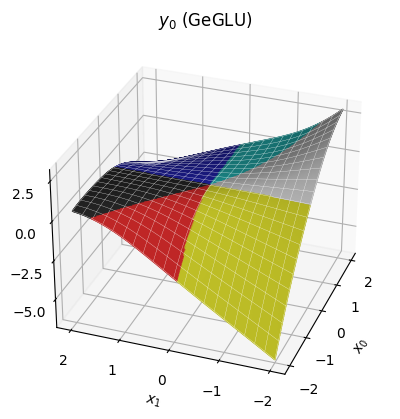

In [31]:
for y, name in [(y_linear, "Linear"), (y_relu, "ReLU"), (y_gelu, "GELU"), (y_reglu, "ReGLU"), (y_geglu, "GeGLU")]:
    _, ax = plt.subplots(subplot_kw=dict(projection="3d"))
    if name == "Linear":
        ax.plot_surface(x[:, :, 0], x[:, :, 1], y[:, :, 0], color="b")
    else:
        ax.plot_surface(x[:, :, 0], x[:, :, 1], y[:, :, 0], facecolors=c.tolist(),
                        rcount=count, ccount=count)
    stride = 10
    ax.plot_wireframe(x[::stride, ::stride, 0], x[::stride, ::stride, 1], .01+y[::stride, ::stride, 0],
                      rcount=count, ccount=count, color="w", lw=.2)
    ax.view_init(30, -60, 0)
    ax.view_init(30, 200, 0)
    ax.zaxis.set_major_locator(matplotlib.ticker.MaxNLocator(4))
    ax.set_xlabel("$x_0$")
    ax.set_ylabel("$x_1$")
    ax.set_title(f"$y_0$ ({name})")

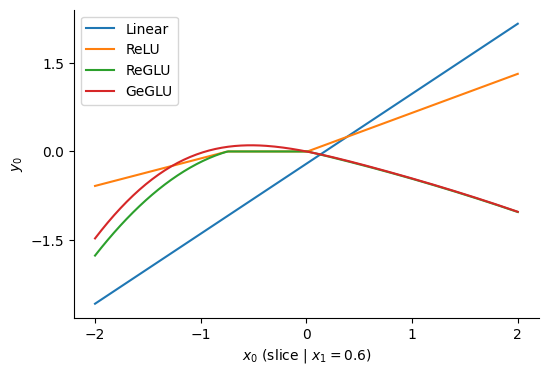

In [32]:
ix1 = int(.65*count)

plt.figure(figsize=(6, 4))
ax = plt.gca()
ax.plot(x[ix1, :, 0], y_linear[ix1, :, 0], label="Linear")
ax.plot(x[ix1, :, 0], y_relu[ix1, :, 0], label="ReLU")
ax.plot(x[ix1, :, 0], y_reglu[ix1, :, 0], label="ReGLU")
ax.plot(x[ix1, :, 0], y_geglu[ix1, :, 0], label="GeGLU")
ax.legend()
ax.set_xticks([-2, -1, 0, 1, 2])
ax.set_xlabel(f"$x_0$ (slice | $x_1={float(x[ix1, 0, 1]):.1f}$)")
ax.set_ylabel("$y_0$")
ax.yaxis.set_major_locator(matplotlib.ticker.MaxNLocator(5))
sns.despine(ax=ax)

## 9. Final norm

In [33]:
def predict_debug(p: Params, input_ids: Tensor) -> Tensor:
    hiddens = p.embedding[input_ids]
    hiddens *= hiddens.shape[-1] ** .5
    for p_attn, p_mlp in p.layers:
        hiddens += attention(p_attn, rms_norm(p_attn.norm, hiddens))
        hiddens += mlp(p_mlp, rms_norm(p_mlp.norm, hiddens))
    global pre_final_norm_hiddens
    pre_final_norm_hiddens = hiddens
    hiddens = rms_norm(p.final_norm, hiddens)
    global post_final_norm_hiddens
    post_final_norm_hiddens = hiddens
    return hiddens @ p.embedding.T

input_ids = tokenizer("I want to move").input_ids
with torch.no_grad():
    predict_debug(params, torch.tensor(input_ids))

In [34]:
print("| Token: | " + " | ".join(
    t.replace("<", "\\<").replace(">", "\\>") for t in tokenizer.convert_ids_to_tokens(input_ids)) + " |")
print("| --: | " + " :-: |" * len(input_ids))
rms = pre_final_norm_hiddens.pow(2).mean(-1).sqrt()
print("| Before RMSNorm, RMS: | " + " | ".join(f"{x:.1f}" for x in rms.tolist()) + " |")
rms = post_final_norm_hiddens.pow(2).mean(-1).sqrt()
print("| After RMSNorm, RMS: | " + " | ".join(f"{x:.1f}" for x in rms.tolist()) + " |")

| Token: | \<bos\> | I | ▁want | ▁to | ▁move |
| --: |  :-: | :-: | :-: | :-: | :-: |
| Before RMSNorm, RMS: | 88.5 | 16.3 | 14.4 | 12.9 | 12.6 |
| After RMSNorm, RMS: | 2.2 | 2.2 | 2.2 | 2.2 | 2.2 |


## 10. Output projection

In [35]:
input_ids = torch.tensor(tokenizer("I want to move").input_ids)
with torch.no_grad():
    logits = predict(params, input_ids)
    scores, ids = torch.sort(torch.log_softmax(logits, -1), -1)

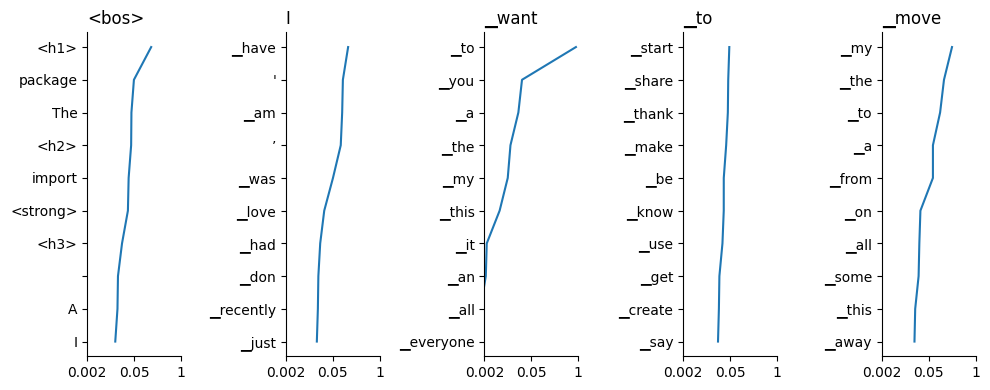

In [36]:
_, axs = plt.subplots(1, 5, figsize=(10, 4))
for ax, s, i, t in zip(axs, scores[:, -10:], ids[:, -10:], tokenizer.convert_ids_to_tokens(input_ids)):
    ax.plot(s, range(len(i)))
    ax.set_yticks(range(len(i)), tokenizer.convert_ids_to_tokens(i))
    ax.set_title(t, loc="left")
    xs = torch.tensor([0, -3, -6])
    ax.set_xticks(xs, [f"{x:.1g}" for x in xs.exp()])
    ax.set_xlim(xs[-1], xs[0])
plt.tight_layout()
sns.despine()